# IS319 - Deep Learning

## TP2 - Dogs vs. cats (PyTorch)

Credits: Baptiste Pesquet

![Woof Meow](woof_meow.jpg)

In this TP, the goal is to train neural networks to classify images of dogs and cats, using the PyTorch library.

The images used in this TP are extracted from the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/) dataset available on Kaggle, which contains 25000 images. First, we use a subset of 2000 images to decrease training time, for educational purposes. Later on, you can experiment with the full dataset using a GPU.

Most questions are open-ended: feel free to experiment with different settings. **Remember to analyze and explain what you are doing in additional cells.**

## Environment setup

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image

PyTorch version: 2.1.0+cu121


## 1. Load and explore the dataset

In [3]:
# Downloading our example data, a .zip of 2000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate --no-clobber \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directories with training/validation cat/dogs pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

# Display the sizes of our dataset
print(f'Number of train cat images: {len(os.listdir(train_cats_dir))}')
print(f'Number of train dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Number of valid cat images: {len(os.listdir(valid_cats_dir))}')
print(f'Number of valid dog images: {len(os.listdir(valid_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
print(train_dog_fnames[:10])

File ‘/tmp/cats_and_dogs_filtered.zip’ already there; not retrieving.
Number of train cat images: 1000
Number of train dog images: 1000
Number of valid cat images: 500
Number of valid dog images: 500
['cat.980.jpg', 'cat.442.jpg', 'cat.306.jpg', 'cat.164.jpg', 'cat.431.jpg', 'cat.187.jpg', 'cat.447.jpg', 'cat.165.jpg', 'cat.87.jpg', 'cat.385.jpg']
['dog.173.jpg', 'dog.593.jpg', 'dog.586.jpg', 'dog.121.jpg', 'dog.82.jpg', 'dog.674.jpg', 'dog.299.jpg', 'dog.542.jpg', 'dog.644.jpg', 'dog.946.jpg']


**(Question)** Display some images of cats and dogs from the train set and the validation set.

In [4]:
# YOUR CODE HERE
valid_cat_fnames = os.listdir(valid_cats_dir)
print(valid_cat_fnames[:10])
valid_dog_fnames = os.listdir(valid_dogs_dir)
print(valid_dog_fnames[:10])

['cat.2239.jpg', 'cat.2388.jpg', 'cat.2205.jpg', 'cat.2356.jpg', 'cat.2342.jpg', 'cat.2085.jpg', 'cat.2168.jpg', 'cat.2249.jpg', 'cat.2389.jpg', 'cat.2037.jpg']
['dog.2409.jpg', 'dog.2149.jpg', 'dog.2492.jpg', 'dog.2143.jpg', 'dog.2208.jpg', 'dog.2024.jpg', 'dog.2134.jpg', 'dog.2321.jpg', 'dog.2406.jpg', 'dog.2339.jpg']


Text(0.5, 1.0, 'valid dog example')

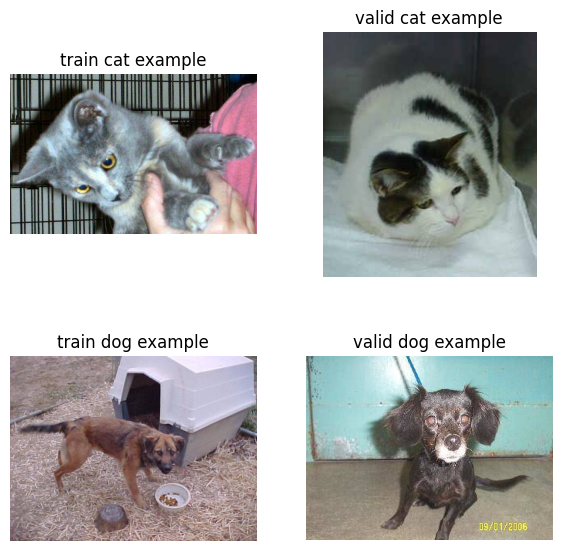

In [5]:
from PIL import Image

fig = plt.figure(figsize=(7, 7)) 
  
# setting values to rows and column variables 
rows, columns = 2, 2
  
# reading images 
train_cat = Image.open(train_cats_dir + '/cat.980.jpg') 
valid_cat = Image.open(valid_cats_dir + '/cat.2205.jpg') 
train_dog = Image.open(train_dogs_dir + '/dog.542.jpg') 
valid_dog = Image.open(valid_dogs_dir + '/dog.2024.jpg') 

# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 
  
# showing image 
plt.imshow(train_cat) 
plt.axis('off') 
plt.title("train cat example") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2) 
  
# showing image 
plt.imshow(valid_cat) 
plt.axis('off') 
plt.title("valid cat example") 
  
# Adds a subplot at the 3rd position 
fig.add_subplot(rows, columns, 3) 
  
# showing image 
plt.imshow(train_dog) 
plt.axis('off') 
plt.title("train dog example") 
  
# Adds a subplot at the 4th position 
fig.add_subplot(rows, columns, 4) 
  
# showing image 
plt.imshow(valid_dog) 
plt.axis('off') 
plt.title("valid dog example") 

## 2. Prepare the dataset

**(Question)** Following the documentation, create a custom `torch.utils.data.Dataset` class to handle your train and validation datasets. Allow this class to resize images and normalize them. Then, create a `DataLoader` for train and validation datasets to handle shuffling and batches.

In [6]:
# YOUR CODE HERE
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

#Dataset class 

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []

        class_names = os.listdir(data_path)
        
        for c in class_names:
            class_path = os.path.join(data_path, c)
            images_names = os.listdir(class_path)
            for i in images_names:
                image_path = os.path.join(class_path, i)
                self.image_paths.append(image_path)
                self.labels.append(image_path.split('/')[-2])
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path) 
        label = self.labels[idx]
        label = 0 if (label=="cats") else 1
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label


#Transform object

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()  # Convert the image to a PyTorch tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Values ???
])


# Datasets

train_dataset = ImageDataset(train_dir, transform=transform)
test_dataset = ImageDataset(valid_dir, transform=transform)


In [7]:

#DataLoader 
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

#train_features, train_labels = next(iter(train_loader))
#test_features, test_labels = next(iter(test_loader))



## 3. Training CNN models

**(Question)** Create a CNN classification model able to be trained on your dataset. Show the model and its number of parameters.

In [8]:
# YOUR CODE HERE

# Creating a CNN class
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(238144, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)

        out = self.sigmoid(out)

        
        return out

    


In [9]:
num_classes = 1
learning_rate = 0.01
num_epochs = 20
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
model = ConvNeuralNet(num_classes)

# Set Loss function with criterion
criterion = nn.BCELoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

**(Question)** Using PyTorch, implement a training loop with your model and an appropriate loss function.

In [11]:
# YOUR CODE HERE

model.to(device)
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        labels = labels.unsqueeze(1)
        labels = labels.float()
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

model.to('cpu')     
            

            
            


Epoch [1/20], Loss: 0.6880
Epoch [2/20], Loss: 0.7007
Epoch [3/20], Loss: 0.6755
Epoch [4/20], Loss: 0.6215
Epoch [5/20], Loss: 0.7012
Epoch [6/20], Loss: 0.6901
Epoch [7/20], Loss: 0.6028
Epoch [8/20], Loss: 0.6544
Epoch [9/20], Loss: 0.6404
Epoch [10/20], Loss: 0.5869
Epoch [11/20], Loss: 0.4823
Epoch [12/20], Loss: 0.4670
Epoch [13/20], Loss: 0.4698
Epoch [14/20], Loss: 0.7066
Epoch [15/20], Loss: 0.2867
Epoch [16/20], Loss: 0.1763
Epoch [17/20], Loss: 0.1532
Epoch [18/20], Loss: 0.1421
Epoch [19/20], Loss: 0.0468
Epoch [20/20], Loss: 0.0324


ConvNeuralNet(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=238144, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

**(Question)** Train your model. Monitor train and validation accuracy. Analyze your results.

In [12]:
# YOUR CODE HERE
model.to(device)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        labels = labels
        outputs = outputs.squeeze()
        outputs = (outputs >= 0.5).float()

        equal_elements = (outputs == labels)
        correct_n = equal_elements.sum().item()
        total += labels.size(0)
        correct += correct_n
print(labels)
print(outputs)

print("Test Acurracy = " + str(correct/total))

        
        

tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
tensor([1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
        0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0.], device='cuda:0')
Test Acurracy = 0.628


In [13]:
model.to(device)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        labels = labels
        outputs = outputs.squeeze()
        outputs = (outputs >= 0.5).float()

        equal_elements = (outputs == labels)
        correct_n = equal_elements.sum().item()
        total += labels.size(0)
        correct += correct_n
print(labels)
print(outputs)

print("Train Acurracy = " + str(correct/total))


tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
tensor([1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.],
       device='cuda:0')
Train Acurracy = 0.999


**(Question)** Make sure your code is using a GPU if one is available. Modify your code accordingly, if necessary. What kind of speedup do you observe? 

## 4. Preventing overfitting

**(Question)** Experiment with various deep learning techniques to prevent overfitting.

Some suggested strategies are:

- Adding data augmentation: possible transformations are random (horizontal) flips, rotations, translations, crops, and zooms
    - (When using data augmentation, it is always good to visualize some of your transformations)
- Adding dropout to the classification part
- Adding appropriate batch normalization layers in different parts of the network

In [14]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

**(Question)** Train your model with deep learning techniques. Analyze the results and compare with the previous model.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## 5. Finetuning a pretrained model

**(Question)** Load the feature extraction part of VGG16 model. The feature extraction part corresponds to the CNN part, without the MLP classifier at the end.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**(Question)** Add a custom MLP classifier on top of the VGG16 feature extraction part.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**(Question)** Train your model. Analyze your results and compare with your initial model trained from scratch.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()